In [ ]:
# Start with transformation pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
num_pipeline = Pipeline([
 ('imputer', Imputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
 ('selector', DataFrameSelector(num_attribs)),
 ('imputer', Imputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])
cat_pipeline = Pipeline([
 ('selector', DataFrameSelector(cat_attribs)),
 ('label_binarizer', LabelBinarizer()),
 ])
full_pipeline = FeatureUnion(transformer_list=[
 ("num_pipeline", num_pipeline),
 ("cat_pipeline", cat_pipeline),
 ])


# Select and train the Model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
# For reducing the underfittting , we should try to use the more advancd training modle for training perpose.

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
# Find the suqure_mean_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Better evaluation using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

# Save the model by using the

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Fine tuning the model

In [ ]:
# For the fine tuning task used the GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)


In [ ]:
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
print(np.sqrt(-mean_score), params)


# Ch - 3

## Classification

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/554. Retrying...
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
mnist['data'][0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [ ]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [ ]:
mnist['target']

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
mnist.data.shape # Here 28 * 28 is pixel size of the image

(70000, 784)

In [ ]:
mnist.target.shape # This code only give the number of the image and there level

(70000,)

In [ ]:
import numpy as np
np.unique(mnist.target)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
# Store the value of the data and tarhet in the different variable
X, y = mnist["data"], mnist["target"]

In [ ]:
X.shape , y.shape

((70000, 784), (70000,))

In [ ]:
# Pick the one digit from data
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28 , 28)


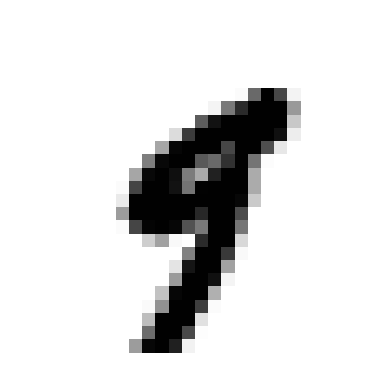

In [ ]:
plt.imshow(some_digit_image , cmap = matplotlib.cm.binary , interpolation = "nearest" )

plt.axis("off")
plt.show()


In [ ]:
# Output look like the 9 digit

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [ ]:
# Suffling the index
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [ ]:
# Training the binary classifier
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [ ]:
# Train the data by using the SGDClassifier

from sklearn.linear_model import SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
# import numpy as np

# # Assume X_train and y_train are already defined properly

# # Create binary target labels for detecting the digit 5
# y_train_5 = (y_train == 5)

# # Check the unique values in y_train_5
# print(np.unique(y_train_5))  # Should output [False  True] if correctly labeled

# Train the SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


In [ ]:
# # Ensure some_digit is reshaped correctly as a 2D array
# some_digit_reshaped = some_digit.reshape(1, -1)

# # Now you can use it for prediction
# sgd_clf.predict([some_digit_reshaped])


# Measure accuracy using crossvalidation



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True , random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495


# Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [ ]:
# Find the confusion matrix between predicted data and the actual target data
from sklearn.matrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


# Precision and Recall

In [ ]:
# Calculate the precision and recall using the class of sklearn metrics
from sklearn.metrics import precision_score , recall_score

precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

In [ ]:
# Also calculate the F1 score which are harmonic mean of the precison and recall
from sklearn.metrics import f1_score
f1_score(y_train_5 , y_pred)


# The ROC Curve

In [ ]:
# receiver operating characteristic curve

from sklearn.metrics import roc_curve

fpr , tpr , threshold = roc_curve(y_train_5 , y_score)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# Evaluate the roc_auc_curve

from sklearn.metrics import roc_auc_curve
roc_auc_score(y_train_5, y_scores)

# MultiClass Classification

In [ ]:
# One v/s All strategy (OvA)

# For the Multiclass Classification , Used the RFC , SVM and Many More ------

# Error Analysis

# MultiLabel Classification

# Implementation of the Gradient Descent

In [ ]:
import numpy as np

In [ ]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance

theta = np.random.randn(2,1) # random initialization
for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients


In [ ]:
print(theta)

[[3.99982602]
 [2.78157141]]


# Implementation of Stochastic Gradient Descent

In [ ]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization
for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [ ]:
print(theta)

[[4.01695377]
 [2.77853135]]


In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())


SGDRegressor(eta0=0.1, max_iter=50, penalty=None)

# Polynomial Regression


In [ ]:
m = 100
X = 6 * np.random.rand(m , 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m , 1)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X[0]

array([-2.17790279])

In [ ]:
X_poly[0]

array([-2.17790279,  4.74326055])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

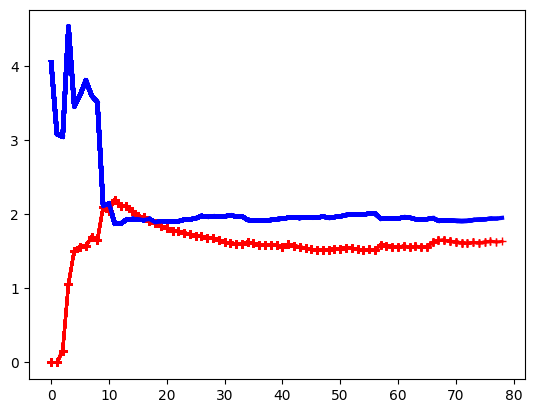

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

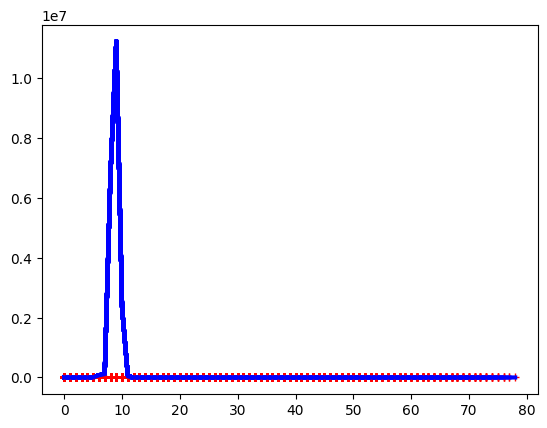

In [ ]:
# Try to used the pipeline for more degree of dimension of the data
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
 ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
 ("sgd_reg", LinearRegression()),
 ))

plot_learning_curves(polynomial_regression , X , y)

In [ ]:
# Implementation of the Ridge Regression
from sklearn.linear_model import Ridge

In [ ]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

#

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])


array([4.45343784])

# Logistic Regression

In [ ]:
import numpy as np

In [ ]:
from sklearn import datasets

In [ ]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
iris['data']

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [ ]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)


LogisticRegression()

In [ ]:
import matplotlib.pyplot as plt

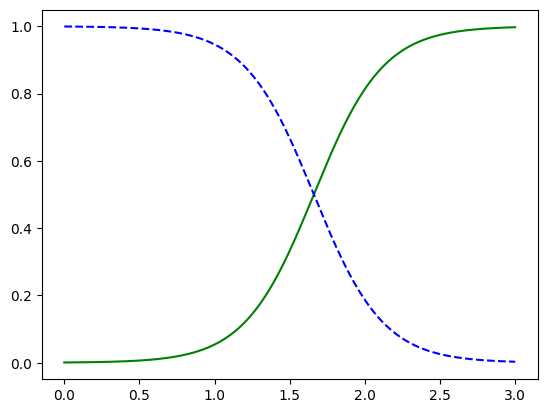

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")
# + more Matplotlib code to make the image look pretty

# Support Vector Machine

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [ ]:
X = iris["data"][:, 3:] # petal width
y = (iris["target"] == 2).astype(float)

In [ ]:
svm_clf = Pipeline((
 ("scaler", StandardScaler()),
 ("linear_svc", LinearSVC(C=1, loss="hinge")),
 ))

svm_clf.fit(X_scaled, y)


In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
polynomial_svm_clf = Pipeline((
 ("poly_features", PolynomialFeatures(degree=3)),
 ("scaler", StandardScaler()),
 ("svm_clf", LinearSVC(C=10, loss="hinge"))
 ))
polynomial_svm_clf.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

In [ ]:
# plot_learning_curves(polynomial_svm_clf , X , y)

In [ ]:
# Implementation of the Non Linear SVM Classification

from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
 ))

poly_kernel_svm_clf.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [ ]:
# Radial Basis Feature (RBF) Kernel
rbf_kernel_svm_clf = Pipeline((
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
 ))

rbf_kernel_svm_clf.fit(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

# SVM Regression

In [ ]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X, y)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=1.5)

In [ ]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

# Quatratic Programming

# Decision Trees


In [ ]:
# Training and Visualizing the decision Tree

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier


In [ ]:
iris = load_iris()
M = iris.data[: , 2:]
n = iris.target


In [ ]:
tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(M , n)

DecisionTreeClassifier(max_depth=2)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",  # corrected this part
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)


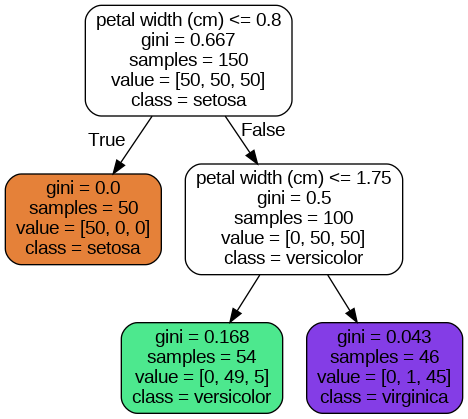

In [ ]:
!dot -Tpng iris_tree.dot -o iris_tree.png


In [ ]:
# Estimating Class Probabilities

tree_clf.predict_proba([[5 , 1.5]])


# Cart Training Algorithm

In [ ]:
# CART stand for the Classification and Regression Tree

# Many stopping condition are applying to stop the splitting and minimize the impurity

# stopping conditions (min_samples_split, min_sam
# ples_leaf, min_weight_fraction_leaf, and max_leaf_nodes

In [ ]:
# Decision tree are also used for the prediction of the regression task


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(M , n)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRgression
from sklearn.svm import SVC

In [ ]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# Here ensemble the all three algorithm together and form the single model

voting_clf = VotingClassifier(
 estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
 voting='hard'
 )
voting_clf.fit(X_train, y_train)


In [ ]:
# Output Look like this
'''
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896

'''
# Ensemble Model produced the better result than individual once.

# Bagging and Pasting

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
 DecisionTreeClassifier(), n_estimators=500,
 max_samples=100, bootstrap=True, n_jobs=-1
 )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


# Out-of-Bag Evaluation


In [ ]:
# It also maintain the rest of the sample which are not going for the training

bag_clf = BaggingClassifier(
 DecisionTreeClassifier(), n_estimators=500,
 max_samples=100, bootstrap=True, n_jobs=-1 , oob_score = True
 )

In [ ]:
  bag_clf.fit(X_train , y_train)

In [ ]:
# Accuracy score is 93.6 %

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

# Adaptive Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=200,
 algorithm="SAMME.R", learning_rate=0.5
 )


ada_clf.fit(X_train, y_train)


# Gradient Boosting

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)

tree_reg2.fit(X, y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)

tree_reg3.fit(X, y3)

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [ ]:
# Implementation  of the Gradient Boosting Regressor Using API Scikit-Learn

from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbrt = GradientBoostingRegressor(max_depth = 2 , n_estimators=3 , learning_rate = 1)

gbrt.fit(X_train , y_train)


In [ ]:
# Implementation of the GBRT using optimal number of tree = 120

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)

gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
 for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

In [ ]:
# Method of early stoping method

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)

  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0

  else:
    error_going_up += 1

  if error_going_up == 5:
    break # early stopping

# Dimensional Reduction

In [ ]:
# All implemetation done on Kaggle


# TensorFlow

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf

In [ ]:
x = tf.Variable(3 , name = 'x')
y = tf.Variable(4 , name = 'y')
f = x * x * y + y + 2

In [ ]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)

print(result)

sess.close()

# Introduction to ANN

In [ ]:
# Implementation of the perceptron using prebuilt class scikit learn

import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris


iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(int) # Iris Setosa?


In [ ]:
X.shape , y.shape

In [ ]:
type(X) , type(y)

In [ ]:
# Now time to train the data using the Perceptrone Algorithm
per_clf = Perceptron(random_state = 42)
per_clf.fit(X , y)

In [ ]:
per_clf.predict([[2 , 0.5]])
# This is predict on the sample data

In [ ]:
# LTU also called the Hidden Layer
# The problem based on the XOR solved by the Multi-Layer Perceptron and Backpropgation.



In [ ]:
!pip

In [ ]:
# import tansorflow as tf

In [ ]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)

dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300, 100], n_classes=10,
 feature_columns=feature_columns)

dnn_clf.fit(x=X_train, y=y_train, batch_size=50, steps=40000)


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = dnn_clf.predict(X_test)

accuracy_score(y_test , y_pred)

In [ ]:
dnn_clf.evaluate(x_test , y_test)

# Traning DNN Using Plain TensorFlow

In [ ]:
# Import tensorflow
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:

n_inputs = 28*28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [ ]:
def neuron_layer(X, n_neurons, name, activation=None):
  with tf.name_scope(name):
    n_inputs = int(X.get_shape()[1])
    stddev = 2 / np.sqrt(n_inputs)
    init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
    W = tf.Variable(init, name="weights")
    b = tf.Variable(tf.zeros([n_neurons]), name="biases")
    z = tf.matmul(X, W) + b
    if activation=="relu":
      return tf.nn.relu(z)
    else:
      return z


In [ ]:
with tf.name_scope("dnn"):
  hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
  hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
  logits = neuron_layer(hidden2, n_outputs, "outputs")


In [ ]:
# Now , use the fully connected layer function for the implementation of the neural network

# Neural Network

from tesnorflow.contrib.layers import fully_connected

with tf.name_scope("dnn"):
  hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
  hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
  logits = fully_connected(hidden2, n_outputs, scope="outputs",
  activation_fn=None)


In [ ]:
# Cost Function

with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
  labels=y, logits=logits)
  loss = tf.reduce_mean(xentropy, name="loss")


In [ ]:
# Implementation of the optimize the networks

learning_rate = 0.01

with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)


In [ ]:
# Evaluate the trained model

with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y, 1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [ ]:
# Save the trained parameter for feature prediction

init = tf.global_variables_initializer()
saver = tf.train.Saver()


# Execution Phase

In [ ]:
# Load the MNIST datasets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")


In [ ]:
# Define the number of the epochs and the size of the batch in each epoch.

n_epochs = 400
batch_size = 50

# Now time to train the model

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(mnist.train.num_examples // batch_size):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
    acc_test = accuracy.eval(feed_dict={X: mnist.test.images,
    y: mnist.test.labels})

    print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

  save_path = saver.save(sess, "./my_model_final.ckpt")

# Using the Neural Network


In [ ]:
# After trained our model , lets try to predict the accuracy score.

with tf.Session() as sess:
  saver.restore(sess, "./my_model_final.ckpt")
  X_new_scaled = [...] # some new images (scaled from 0 to 1)
  Z = logits.eval(feed_dict={X: X_new_scaled})
  y_pred = np.argmax(Z, axis=1)


# Fine-Tuning Neural Network Hyperparameters

In [ ]:
# For the fine tuning the model , we take the various action for that like
'''
1) Accuracy of the model depend on the number of the Hidden layers
2) Number of the neurons in the single hidden layers
3) The activation function played a vital role in the decision on the model's accuracy.
'''

# CHAPTER 11
## Training Deep Neural Nets


In [ ]:
'''
There are many problem for improving the model accuracy and performance such as

1) First, you would be faced with the tricky vanishing gradients problem (or the
related exploding gradients problem) that affects deep neural networks and makes
lower layers very hard to train.

2) Second, with such a large network, training would be extremely slow.

3) Third, a model with millions of parameters would severely risk overfitting the training set.

'''

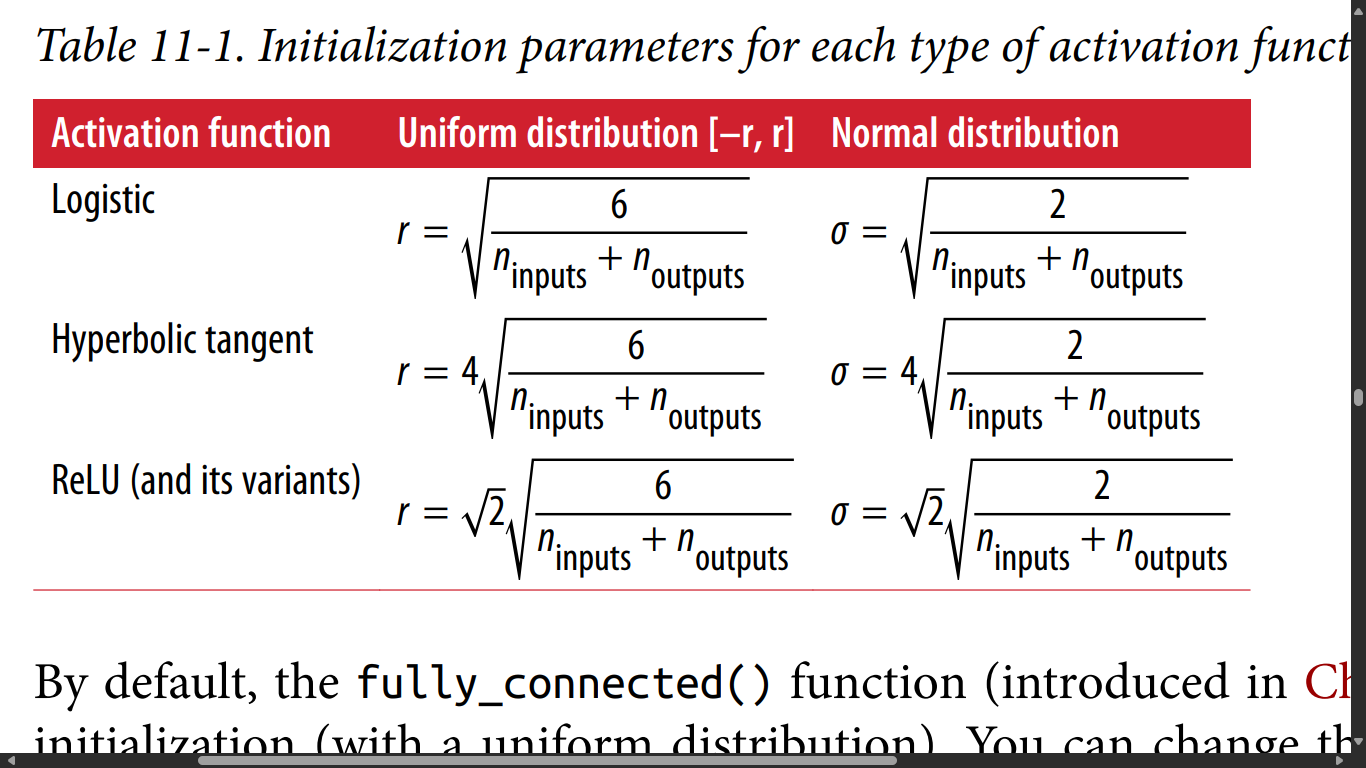

In [ ]:
# Convert the Xavier-Initialization into He-Intialization

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = fully_connected(X, n_hidden1, weights_initializer=he_init, scope="h1")

In [ ]:
# Order of activation function
# ELU > Leaky ReLU > tanh > Logistic
# But if you have less time than , Leaky ReLU > ELU
# Implementation

# Apply elu
hidden1 = fully_connected(X, n_hidden1, activation_fn=tf.nn.elu)

# Apply Leacky ReLU
def leaky_relu(z, name=None):
  return tf.maximum(0.01 * z, z, name=name)

hidden1 = fully_connected(X, n_hidden1, activation_fn=leaky_relu)



# Batch Normalization

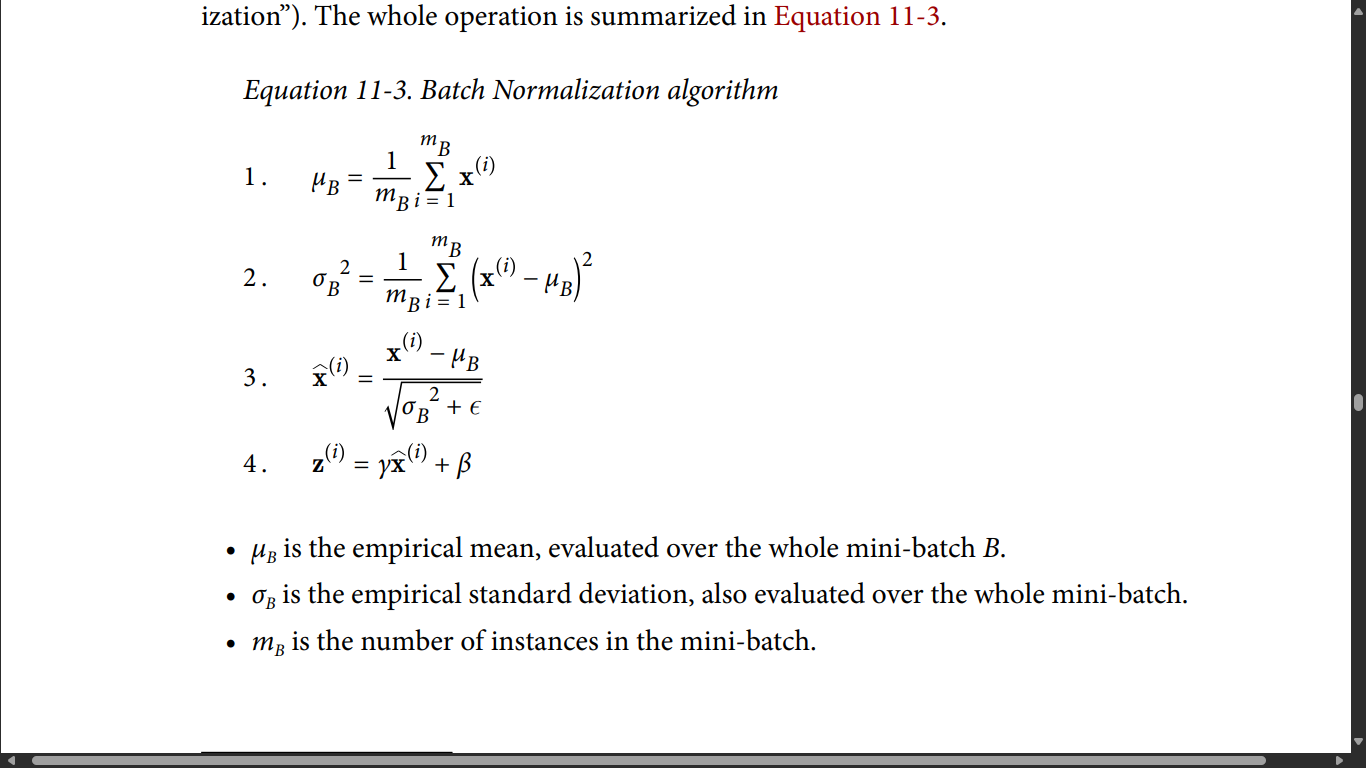

In [ ]:
# Implementing Batch Normalization with TensorFlow

import tensorflow as tf
from tensorflow.contrib.layers import batch_norm

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')


bn_params = {
 'is_training': is_training,
 'decay': 0.99,
 'updates_collections': None
}


hidden1 = fully_connected(X, n_hidden1, scope="hidden1",
 normalizer_fn=batch_norm, normalizer_params=bn_params)

hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2",
 normalizer_fn=batch_norm, normalizer_params=bn_params)

logits = fully_connected(hidden2, n_outputs, activation_fn=None,scope="outputs",
 normalizer_fn=batch_norm, normalizer_params=bn_params)


In [ ]:
with tf.contrib.framework.arg_scope(
 [fully_connected],
 normalizer_fn=batch_norm,
 normalizer_params=bn_params):
 hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
 hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
 logits = fully_connected(hidden2, n_outputs, scope="outputs",
 activation_fn=None)

In [ ]:
with tf.Session() as sess:
 sess.run(init)
 for epoch in range(n_epochs):
 [...]
 for X_batch, y_batch in zip(X_batches, y_batches):
  sess.run(training_op,
  feed_dict={is_training: True, X: X_batch, y: y_batch})


accuracy_score = accuracy.eval(
  feed_dict={is_training: False, X: X_test_scaled, y: y_test})
print(accuracy_score)


# Gradient Clipping


In [ ]:
# Implementation of the gradient cliping

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
 for grad, var in grads_and_vars]

training_op = optimizer.apply_gradients(capped_gvs)

# Reusing Pretrained Layers

In [ ]:
# Implementation of the pre-trained layers

with tf.Session() as sess:
  saver.restore(sess, "./my_original_model.ckpt")



In [ ]:
init = tf.global_variables_initializer()

reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
 scope="hidden[123]")

reuse_vars_dict = dict([(var.name, var.name) for var in reuse_vars])
original_saver = tf.Saver(reuse_vars_dict) # saver to restore the original model
new_saver = tf.Saver() # saver to save the new model

with tf.Session() as sess:
  sess.run(init)
  original_saver.restore("./my_original_model.ckpt") # restore layers 1 to 3
  [...] # train the new model
  new_saver.save("./my_new_model.ckpt") # save the whole model

# Reusing Models from Other Frameworks

In [ ]:
original_w = [...] # Load the weights from the other framework
original_b = [...] # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
[...] # # Build the rest of the model

# Get a handle on the variables created by fully_connected()
with tf.variable_scope("", default_name="", reuse=True): # root scope
  hidden1_weights = tf.get_variable("hidden1/weights")
  hidden1_biases = tf.get_variable("hidden1/biases")

# Create nodes to assign arbitrary values to the weights and biases
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=(n_hidden1))
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
  sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
  [...] # Train the model on your new task


# Momentum Optimizer

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
 momentum=0.9)

# RMSProp Optimizer

In [ ]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                        momentum=0.9, decay=0.9, epsilon=1e-10)


# Adam Optimizer

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# ℓ1and ℓ2 Regularization

In [ ]:
base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
reg_losses = tf.reduce_sum(tf.abs(weights1)) + tf.reduce_sum(tf.abs(weights2))
loss = tf.add(base_loss, scale * reg_losses, name="loss")


# DropOut

In [ ]:
from tensorflow.contrib.layers import dropout

is_training = tf.placeholder(tf.bool, shape=(), name='is_training')
keep_prob = 0.5

X_drop = dropout(X, keep_prob, is_training=is_training)
hidden1 = fully_connected(X_drop, n_hidden1, scope="hidden1")
hidden1_drop = dropout(hidden1, keep_prob, is_training=is_training)
hidden2 = fully_connected(hidden1_drop, n_hidden2, scope="hidden2")
hidden2_drop = dropout(hidden2, keep_prob, is_training=is_training)
logits = fully_connected(hidden2_drop, n_outputs, activation_fn=None,
 scope="outputs")



In [ ]:
'''
* There different type of the regularization technique for reduce the overfitting like
1) Early stoping
2) Dropout
3) Max-Norm Normalization
4) l1 and l2 Regularization
5)
'''

# CH. = 13
## Convolutional Neural Networks


In [ ]:
!pip install tensorflow

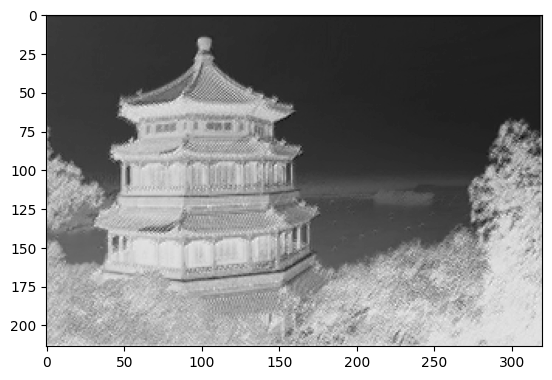

In [ ]:
import numpy as np
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt

# Load sample images
dataset = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters_test = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters_test[:, 3, :, 0] = 1  # vertical line
filters_test[3, :, :, 1] = 1  # horizontal line

# Define a convolutional layer
conv_layer = tf.keras.layers.Conv2D(
    filters=2, kernel_size=7, strides=2, padding="same", use_bias=False
)

# Perform the convolution operation
output = conv_layer(dataset)

# Plot the first image's 2nd feature map
plt.imshow(output[0, :, :, 1], cmap="gray")
plt.show()



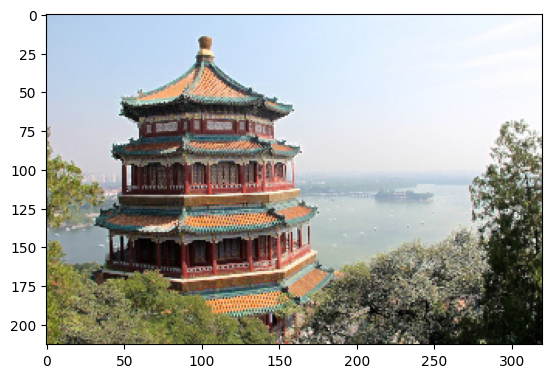

In [ ]:
# Load sample images
dataset = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Define max pooling operation in TensorFlow 2.x style
max_pool = tf.nn.max_pool2d(dataset, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# Since TensorFlow 2.x runs eagerly, no session is needed
output = max_pool

# Plot the output for the 1st image
plt.imshow(output[0].numpy().astype(np.uint8))  # Convert to uint8 for display
plt.show()

# CHAPTER 16
# Reinforcement Learning


In [ ]:
# Try to understand in basic way.
!pip install gym


In [ ]:
import gym

In [ ]:
env = gym.make("CartPole-v0")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v0>>>>>>

In [ ]:
obs = env.reset()
obs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([-0.0400593 , -0.00495882,  0.01091922, -0.00719208], dtype=float32)

In [ ]:
env.render()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
img = env.render(mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
img.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(400, 600, 3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
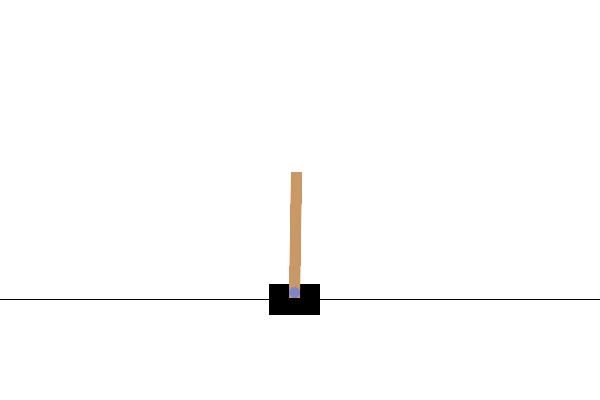

In [ ]:
img

In [ ]:
env.action_space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Discrete(2)

In [ ]:
action = 1
obs , reward , done , info = env.step(action)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
print(obs)
print(reward)
print(done)
print(info)

[-0.04015848  0.19000486  0.01077538 -0.29640996]
1.0
False
{}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Hardcoded the policies

def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1
totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(1000): # 1000 steps max, we don't want to run forever
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
    totals.append(episode_rewards)


In [ ]:
import numpy as np

np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(21.877311417669503, 13.336178208330878, 1.0, 67.0)

# RNN(Recurrent Neural Network)

In [ ]:
# It is very basic and starting point of the Sequencial model and Seq2Seq Model like Transformer , BERT , Llamma , Hugging Face , Pipeline and many more ....


